# Model Comparison
By: Griffin Hosseinzadeh (2025 May 7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll start by generating some synthetic data from a slightly more complicated model than usual. The true underlying model will be a straight line plus a sinusoid. Imagine, for example, that these data are measurements of the brightness of a variable star over time. It could have short-timescale oscillations in brightness while also increasing in average brightness over the long term. Let's model this as
$$ y_3(x) = m x + b + a\sin(2\pi x) $$
where the three model parameters are the slope $m$, the intercept $b$, and the amplitude of the oscillations $a$.
We're going to compare this model with a simpler model without the oscillations:
$$ y_2(x) = m x + b $$
When we have noisy data, we may not be able to tell the difference between these two models.

First, write both these models down as function. We will want to call them later on.

In [14]:
def model3(x, m, b, a):
    return   (m * x + b + a * np.sin ( 2 * np.pi * x))

def model2(x, m, b):
    return   (m * x + b)

Generate 100 random points in the range $0<x<1$ and evaulate the true model ($y_3$) at these points given the parameters below. Then add Gaussian noise to each point using the value of $\sigma$ below. Plot your synthetic data set (with error bars) and visually compare it with your two proposed models.

[50.         50.16443402 50.32861266 50.49228155 50.65518839 50.81708395
 50.97772306 51.13686562 51.29427754 51.44973173 51.60300894 51.75389872
 51.90220022 52.04772302 52.19028788 52.32972747 52.46588705 52.59862508
 52.72781381 52.85333978 52.97510426 53.09302369 53.20702998 53.31707079
 53.42310976 53.52512665 53.6231174  53.71709417 53.80708527 53.89313509
 53.97530385 54.05366743 54.12831701 54.19935874 54.26691329 54.33111538
 54.39211321 54.45006791 54.50515284 54.55755293 54.6074639  54.65509153
 54.70065076 54.74436488 54.78646459 54.8271871  54.86677518 54.90547614
 54.94354089 54.98122288 55.01877712 55.05645911 55.09452386 55.13322482
 55.1728129  55.21353541 55.25563512 55.29934924 55.34490847 55.3925361
 55.44244707 55.49484716 55.54993209 55.60788679 55.66888462 55.73308671
 55.80064126 55.87168299 55.94633257 56.02469615 56.10686491 56.19291473
 56.28290583 56.3768826  56.47487335 56.57689024 56.68292921 56.79297002
 56.90697631 57.02489574 57.14666022 57.27218619 57.

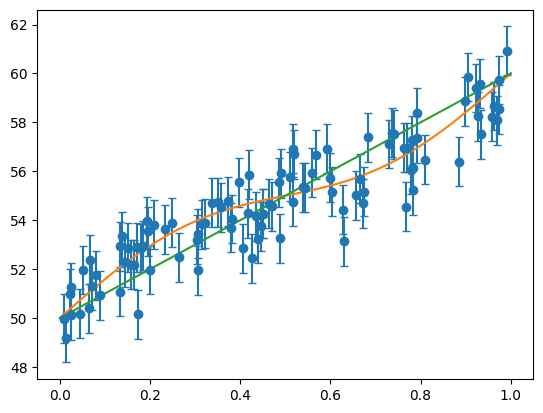

In [24]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 1.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0,1,N)
y_noise_free = model3(x,m_true,b_true,a_true)
y =  y_noise_free + np.random.normal(0,sigma,N)
dy =  sigma #make into an array

x_model = np.linspace(0,1,100)
y_model2 = model2(x_model, m_true, b_true)
y_model3 =  model3(x_model, m_true, b_true, a_true)
print(y_model3)

plt.errorbar(x, y, yerr=sigma, fmt="o", capsize=3)
plt.plot(x_model, y_model3)
plt.plot(x_model, y_model2)



From now on, we are pretending we don't know which model is true, or what the true values of the parameters are. We have a data set, and we want to figure out which model is a a better fit, and whether it is significantly better or not, given the different numbers of parameters.

For each model, write down functions for the logarithm of the prior, likelihood, and posterior. **Make sure your prior is properly normalized.** Use these functions to calculate the Bayesian evidence for each model. This is very similar to what we did in the Bayesian statistics exercise, with one additional step: numerical integration (`np.trapezoid`) of the entire posterior grid.

In [49]:
print(1./99.)

0.010101010101010102


In [52]:
m_min = 0.5  # technically cannot be =0 for a log-uniform prior
m_max = 99.5
b_min = 0.5
b_max = 99.5


def log_prior2(theta):
    if m_min<theta[0]<m_max:
        m_prior=0.010101010101010102
    else:
        m_prior=0

    if b_min<theta[1]<b_max:
        b_prior=0.010101010101010102
    else:
        b_prior=0

    #ln_prior=np.log(b_prior*m_prior)
    
    
    ln_prior=(b_prior*m_prior)################################################################
    
    return ln_prior

def log_likelihood2(theta, x, y, dy):
    modelval = theta[0] * x + theta[1]
    val = ( -0.5 ) * ( np.log ( 2 * np.pi * sigma ** 2 ) + ( ( y - modelval )/ sigma ) ** 2 )
    log_lik = np.sum(val)
    return log_lik

def log_posterior2(theta, x, y, dy):
    return log_likelihood2(theta,x,y,dy) + log_prior2(theta)


m_range2 =  np.linspace(m_min,m_max,N)
b_range2 = np.linspace(b_min,b_max,N)
#theta2 = [m,b]  
posterior_grid2 = np.zeros(shape=(N,N))

for i in range(len(m_range2)):
    for j in range(len(b_range2)):
        posterior_grid2[i,j]= log_posterior2([m_range2[i],b_range2[j]],x,y,dy)




val = np.trapezoid(posterior_grid2, m_range2, axis = 0)
evidence2 = np.trapezoid(val, b_range2, axis = 0)
print(evidence2)

-771352075.2372954


In [51]:
a_min = 0.1
a_max = 10.


def log_prior3(theta):
    # complete

def log_likelihood3(theta, x, y, dy):
    # complete

def log_posterior2(theta, x, y, dy):
    # complete


m_range3 =  # complete
b_range3 =  # complete
theta3 =  # complete
posterior_grid3 =  # complete

evidence3 =  # complete
print(evidence3)

IndentationError: expected an indented block after function definition on line 5 (2905270924.py, line 8)

Calculate the odds ratio for the 3-parameter model compared to the 2-parameter model. What does this number tell you? Does it agree with your intuition from the plot you made above?

In [ ]:
# complete

*Complete*

Now calculate the Akaike and Bayesian information criteria (AIC & BIC). For the sake of time, do not worry about determining the actual maximum-likelihood parameter values. Just use the true parameter values we used to synthesize the data at the beginning of this notebook. (Presumably those should be close to the maximum-likelihood values.) What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

In [ ]:
# complete
# complete
# complete

aic2 =  # complete
aic3 =  # complete
print(aic2, aic3, aic2 - aic3)

bic2 =  # complete
bic3 =  # complete
print(bic2, bic3, bic2 - bic3)

*Complete*

Now repeat this entire notebook using a different data set with increased noise. Either duplicate this entire notebook (File > Duplicate), in which case you need to add that new notebook to the GitHub repository, or copy all the code cells above and paste them below. *(Yes, you could just change the number and rerun the notebook, but we want to see a record of both.)*

This time, increase $\sigma$ to 5. Comment on your results, specifically whether or not you can distinguish between the two models, and whether you think that is reasonable or not.

*Complete*